# Quickstart

Assuming some level of knowledge with the blackjax style, the following is a minimum working example of a basic sampling problem 

In [1]:
import jax
import jax.numpy as jnp
import blackjax
import tqdm 
from blackjax.ns.utils import finalise

rng_key = jax.random.PRNGKey(0)

loglikelihood_function = lambda x: jax.scipy.stats.multivariate_normal.logpdf(x, jnp.ones(5),jnp.eye(5)*0.01)
algo = blackjax.nss(
    logprior_fn=lambda x : jax.scipy.stats.norm.logpdf(x).sum(),
    loglikelihood_fn=loglikelihood_function,
    num_delete=50,
    num_inner_steps=20,
)

rng_key, sampling_key, initialization_key = jax.random.split(rng_key, 3)
state = algo.init(jax.random.normal(initialization_key, (1000, 5)))

@jax.jit
def one_step(carry, xs):
    state, k = carry
    k, subk = jax.random.split(k, 2)
    state, dead_point = algo.step(subk, state)
    return (state, k), dead_point

dead = []

with tqdm.tqdm(desc="Dead points", unit=" dead points") as pbar:
    while (not state.logZ_live - state.logZ < -3):
            (state, rng_key), dead_info = one_step((state, rng_key), None)
            dead.append(dead_info)
            pbar.update(50)

final_state = finalise(state, dead)

Dead points: 16300 dead points [00:01, 10751.72 dead points/s]


## Visualisation

This final state can be used for a number of computations, we display this more in [basic user walkthrough](basic.ipynb), for now we show how to dump the output into the pip installable anesthetic visualisation tool (https://github.com/handley-lab/anesthetic)

In [3]:
import anesthetic
import numpy as np

nested_samples = anesthetic.NestedSamples(
    data = final_state.particles,
    logL = final_state.loglikelihood,
    logL_birth = final_state.loglikelihood_birth,
)

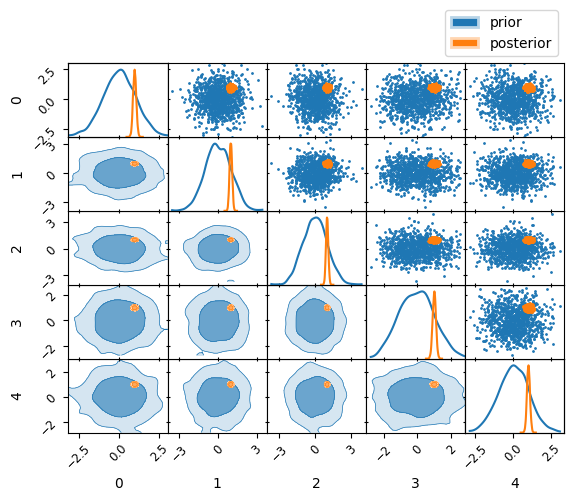

In [4]:
prior = nested_samples.set_beta(0.0).plot_2d(np.arange(5), label="prior")
post = nested_samples.plot_2d(prior, label= "posterior")
prior.iloc[-1, 0].legend(bbox_to_anchor=(len(prior), len(prior)), loc='lower right')
